<a href="https://colab.research.google.com/github/MishterBluesky/Conservation-Colab/blob/main/Automatic_Weblogo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic (and 3D) 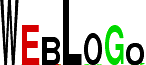

This colab workspace allows for automatic conservation analysis, in the absence of the updated Weblogo and Consurf servers. Check run all and download the weblogo.png and .txt files to understand the most conserved residues. It then also adds this to the b-factor of an alphafold generated model, to show this in 3D.


It uses this gitlab - https://github.com/WebLogo/weblogo as well as Colabfold servers to generate the a3m files for alignment.

This workbook is based greatly off the Alphafold colab notebook here: https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb#scrollTo=G4yBrceuFbf3  and published here:

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

To cite this simple notebook that combines these elements please use: [Graham C, Stansfeld P and Rodrigues C, Conservation-Colab :Conservation to 3D Structure, Github (2023)](https://zenodo.org/doi/10.5281/zenodo.10062701) 


In [ ]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MLKKGPAVIG ATCLTSALLL SGCGLFQSDK AAEEIDPPQD VTFVNDEAGA NSNTTAAKKT ESEKSDTAKA DQASSTVMRE LYLIDKNGYV VAQTLPLPKS ESTAKQALEY LVQGGPVSEI LPNGFRAVLP ADTTVNVDIK  KDGTAIADFS NEFKNYKKED EQKIVQSVTW TLTQFSSIDK VKLRINGHEL KEMPVGGTPI SDDLSRKDGI NLETAGVNDL TATHPLTVYY LAENEDSEYY VPVTKRIDNS EKDDITAAIN ELAKGPSKVS GLLTDFSEDV  KLVSKPKIKD GRVTLDFNQS IFGSADEKTK MISSEVLNSI VLTLTEQPDV KSVSVKVNGK SELVNEKGEK LTEPVSRPSQ VNTGSF' #@param {type:"string"}

jobname = 'GerM' #@param {type:"string"}
# number of models to use
num_relax = 0

template_mode = "pdb100"


use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname GerM_2755a
sequence MLKKGPAVIGATCLTSALLLSGCGLFQSDKAAEEIDPPQDVTFVNDEAGANSNTTAAKKTESEKSDTAKADQASSTVMRELYLIDKNGYVVAQTLPLPKSESTAKQALEYLVQGGPVSEILPNGFRAVLPADTTVNVDIKKDGTAIADFSNEFKNYKKEDEQKIVQSVTWTLTQFSSIDKVKLRINGHELKEMPVGGTPISDDLSRKDGINLETAGVNDLTATHPLTVYYLAENEDSEYYVPVTKRIDNSEKDDITAAINELAKGPSKVSGLLTDFSEDVKLVSKPKIKDGRVTLDFNQSIFGSADEKTKMISSEVLNSIVLTLTEQPDVKSVSVKVNGKSELVNEKGEKLTEPVSRPSQVNTGSF
length 366


In [ ]:
#@markdown ### Install Dependencies

%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version


if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

!python -m pip install --upgrade pip
!pip install tr-rosetta-pytorch
!apt-get install pymol
!touch TRROSETTA_READY

In [ ]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "1" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1
use_dropout = False

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False
save_recycles = False
save_to_google_drive = False
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 300


if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

In [ ]:
# @title Run Alignment { display-mode: "form" }
display_images = False

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=1,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=True,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [ ]:
#@title Run WebLogo: Conservation of protein{ display-mode: "form" }

os.chdir("/content")
import zipfile
import os

# Specify the file path and target folder
zip_file_path = f"/content/{jobname}/{jobname}.result.zip"  # Replace {jobname} with your job name
target_folder = "/content"

# Extract the contents of the ZIP file to the target folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

# List the contents of the target folder


!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()
os.chdir("/content")
!egrep -v '#|>' /content/{jobname}.a3m | sed 's/[a-z]//g' | sort -u > paired.aln
!tr_rosetta paired.aln
!conda install -c bioconda weblogo -y
!weblogo --format PNG < paired.aln > weblogo.png
!weblogo --format logodata < paired.aln > weblogo.txt
import matplotlib.pyplot as plt
from PIL import Image

# Provide the path to your uploaded image
image_path = '/content/weblogo.png'
image = Image.open(image_path)
width = 600
height = 1200
# Display image properties (width, height, mode)
width, height = image.size
mode = image.mode
print(f"Image loaded successfully. Dimensions: {width}x{height}, Mode: {mode}")
image.show()
import matplotlib.pyplot as plt

# Load and read the image using PIL or OpenCV
image_path = '/content/weblogo.png'
image = Image.open(image_path)  # Uncomment this line if using PIL

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()
weblogo_path = os.path.join(target_folder, "weblogo.txt")
if os.path.exists(weblogo_path):
    with open(weblogo_path, "r") as weblogo_file:
        weblogo_contents = weblogo_file.read()
        print("Contents of weblogo.txt:")
        print(weblogo_contents)
else:
    print("weblogo.txt not found in the extracted contents.")

In [ ]:
# @title PDB File loader.
# @markdown This code will take an alphafold model of your protein and ajoin the conservation data above, to the b factor. Thus allowing you to visualise conservation in 3D, when using protein viewing software such as PyMOL. Use of the preset 'B factor putty' is one example of this.
import numpy as np
from Bio.PDB import PDBParser, PDBIO
from Bio.PDB.StructureBuilder import StructureBuilder

# Define the input PDB file and weblogo.txt file
pdb_filename = f'{jobname}_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb'
weblogo_filename = 'weblogo.txt'

# Read entropy values from weblogo.txt
entropy_values = []
with open(weblogo_filename, 'r') as weblogo_file:
    for line in weblogo_file:
        if not line.startswith("#"):
            data = line.split()
            entropy = float(data[-4])  # Extract entropy value (4th from the end)
            entropy_values.append(entropy)

# Read the PDB file
parser = PDBParser(QUIET=True)
structure = parser.get_structure('protein', pdb_filename)

# Modify the beta factor of atoms based on entropy values
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                residue_index = residue.id[1] - 1  # Adjust for 0-based index
                if residue_index < len(entropy_values):
                    beta_factor = entropy_values[residue_index] ** 2  # Square the entropy value
                    atom.set_bfactor(beta_factor)

# Save the modified PDB file
output_filename = pdb_filename.replace('_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb', '_weblogo.pdb')
io = PDBIO()
io.set_structure(structure)
io.save(output_filename)

print(f"Modified PDB file saved as {output_filename}")


Modified PDB file saved as GerM_2755a_weblogo.pdb


In [ ]:
#@title Package and download results
# @markdown Here the workbook will download the weblogo.png and txt files to your computer, as well as a pdb file with the High Entropy conservation mapped onto the structure in the b factor field. If this doesnt work, they are available by clicking on the folder icon, and finding the files under their job names, under weblogo.txt, weblogo.png and jobname_weblogo.pdb

os.chdir(f"/content")
files.download("weblogo.png")
files.download("weblogo.txt")
files.download(f'{jobname}_weblogo.pdb')




# Example output: SpoIIP from Bacillus subtilis

The output from this workbook will be printed above, as a .txt file, but this workbook also creates a .png file from this .txt file.

The .png file looks similar to this example, with the larger letters having higher conservation.
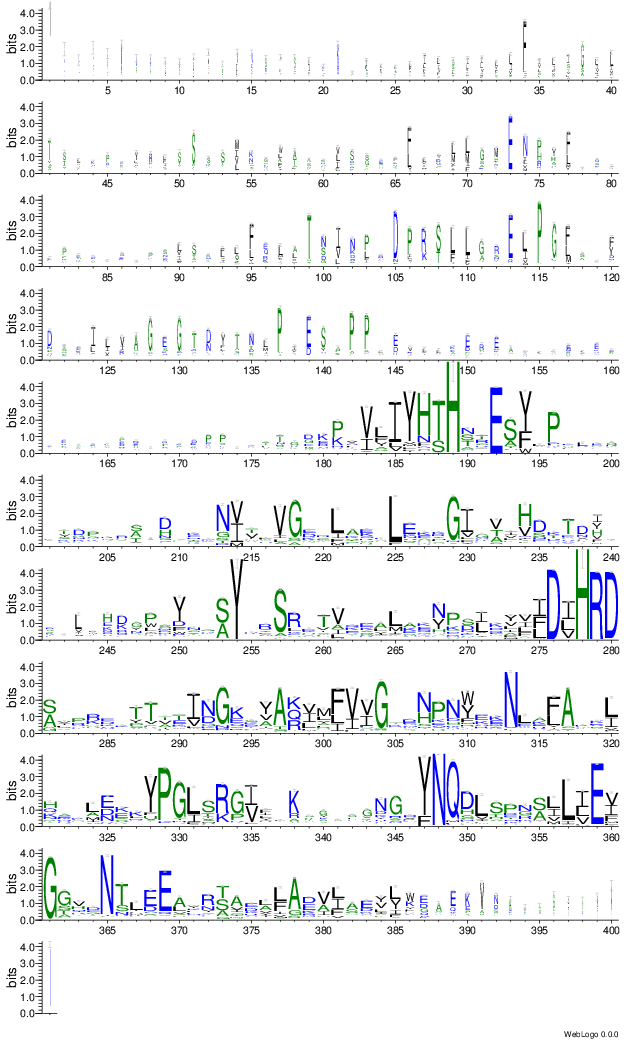

The text file output from weblogo is as follows, as described in https://github.com/WebLogo/weblogo:

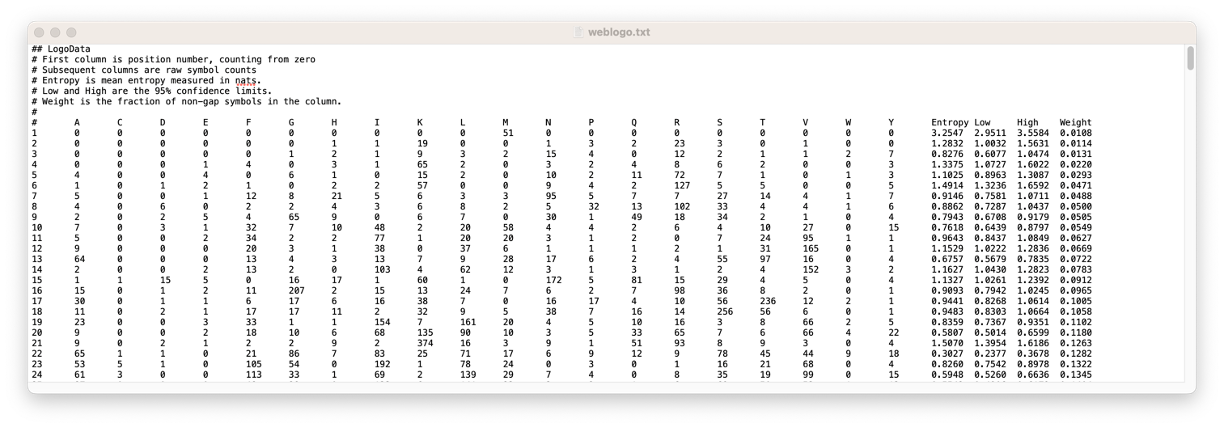

and this workbook also uses alphafold to create a pdb loaded with the entropy value for each amino acid squared, which when viewed in the preset 'B factor putty' in PyMOL appears similar to  below, with red being high and blue being low entropy/conservation.

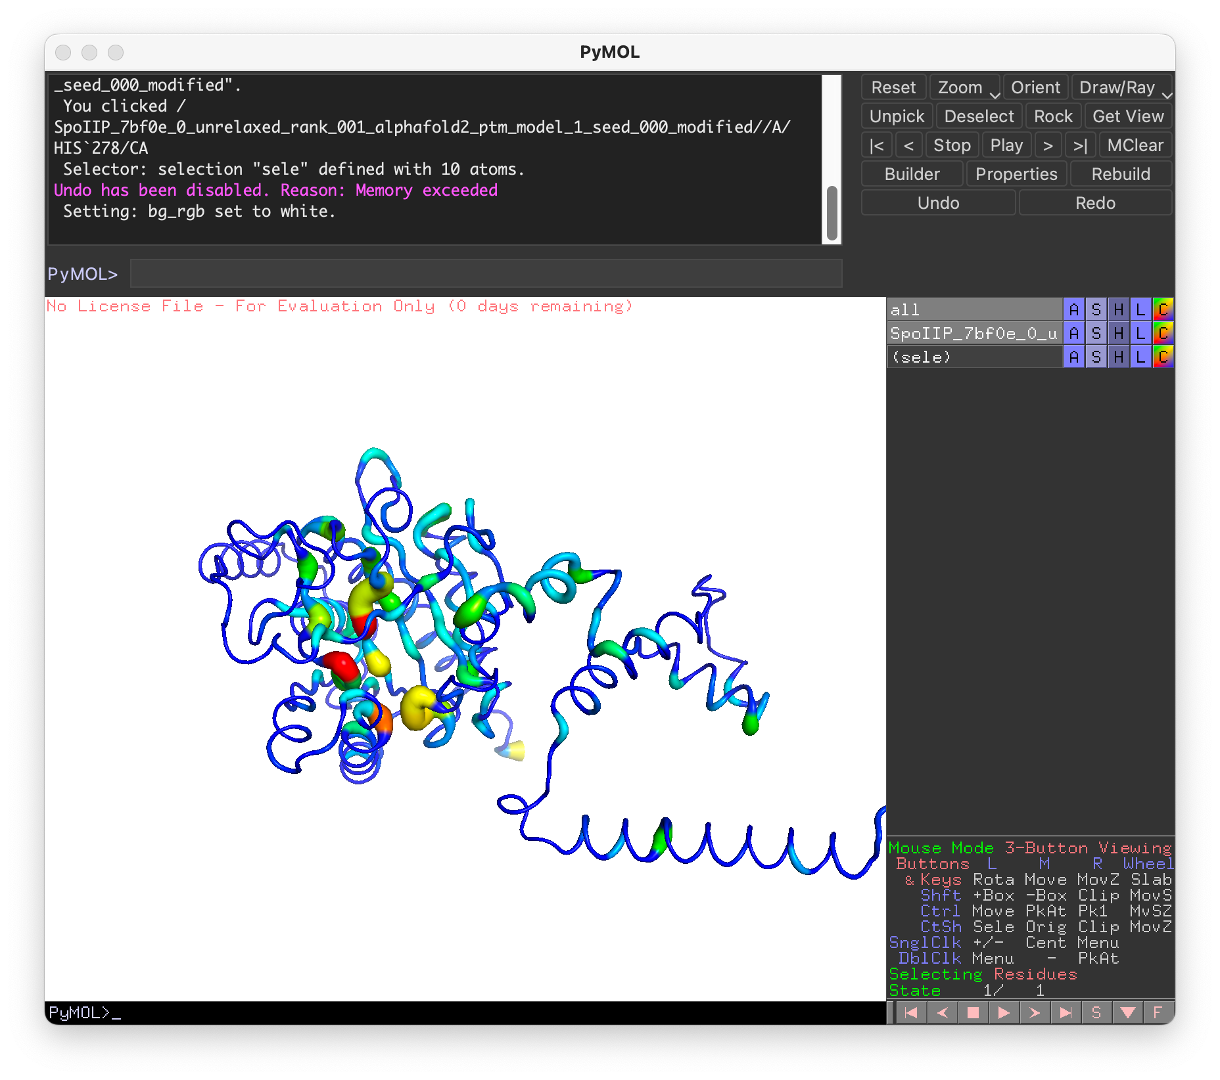




**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
*One must run the pipeline in order, due to dependencies.

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to (https://rawgithubusercontent.com/sokrypton/ColabFold/main/LICENSE)

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

Read more about weblogo and its license here: https://github.com/WebLogo/weblogo

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [Phillip Stansfeld](https://warwick.ac.uk/fac/sci/lifesci/people/pstansfeld/) and [Chris LB Graham](https://twitter.com/ChrisLBGraham)  for attaching weblogo as well as the conservation to pdb b factor addition.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server. Which this conservation server relies upon.

- Inspired by a colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)), Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)),